# Trading Strategies

Let's start with a classic and simple trading strategy: the moving average crossover. The idea behind this strategy is to buy a stock when its fast simple moving average (SMA) crosses above its slow SMA and to short it when the fast SMA crosses below the slow SMA.

Let's start with our imports in the cell below, and preparing our data frame in the cell below that.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("ggplot")

This time we'll fetch our data directly from yfinance.

In [2]:
import yfinance as yf

df = yf.download("JPM",start="2025-01-01")

df.columns = df.columns.droplevel(1) # To get rid of the Multi index

#the first index in Python is 0

df

/tmp/ipykernel_37149/1916630866.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("JPM",start="2025-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2025-01-02,237.305161,240.548330,236.761333,238.214828,9220900
2025-01-03,240.548340,242.130380,237.562246,241.151491,9491100
2025-01-06,239.375565,244.185931,239.107213,242.208108,9917800
2025-01-07,241.681351,243.758552,239.425243,240.657657,8753400
2025-01-08,241.641602,242.754740,239.027697,241.263923,8675300
...,...,...,...,...,...
2025-06-12,268.239990,268.290009,265.140015,266.859985,6618000
2025-06-13,264.950012,267.019989,262.709991,265.079987,7098300
2025-06-16,270.359985,271.730011,266.850006,267.000000,8566000


## Compute and Plot SMAs

Before we can implement our strategy, we need to calculate the fast (short-term) and slow (long-term) SMAs. For this example, we'll use 20-day and 50-day SMAs.

In [3]:
FAST = 5
SLOW = 10

# these are constants

df["FastMA"] = df.Close.rolling(FAST).mean()
df["SlowMA"] = df.Close.rolling(SLOW).mean()
df

Price,Close,High,Low,Open,Volume,FastMA,SlowMA
Date,,,,,,,
2025-01-02,237.305161,240.548330,236.761333,238.214828,9220900,NaN,NaN
2025-01-03,240.548340,242.130380,237.562246,241.151491,9491100,NaN,NaN
2025-01-06,239.375565,244.185931,239.107213,242.208108,9917800,NaN,NaN
2025-01-07,241.681351,243.758552,239.425243,240.657657,8753400,NaN,NaN
2025-01-08,241.641602,242.754740,239.027697,241.263923,8675300,240.110403,NaN
...,...,...,...,...,...,...,...
2025-06-12,268.239990,268.290009,265.140015,266.859985,6618000,267.491998,265.856000
2025-06-13,264.950012,267.019989,262.709991,265.079987,7098300,267.335999,265.951001
2025-06-16,270.359985,271.730011,266.850006,267.000000,8566000,268.059998,266.520999



Remember we'll have a window-length of NaNs in our data frame. This is because we don't have enough data points to calculate an N-day moving average until the Nth day. 
Let's plot the closing price with the SMAs to visually inspect the crossover points.

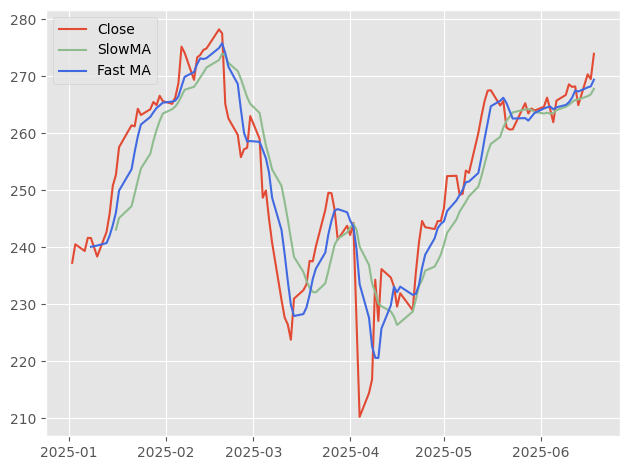

In [4]:
# Figure, size, title, xlabel, ylabel, legend
plt.plot(df.Close, label = "Close")
plt.plot(df.SlowMA, label="SlowMA", color="darkseagreen")
plt.plot(df.FastMA, label="Fast MA", color="royalblue")
plt.legend()
plt.tight_layout()

# there is an upswing once the FastMA is above the SlowMA, that's a signal to buy. When FastMA is under the SlowMA, that's a sigal to sell (enter short as market is falling)

# it takes 5 days for a 5-day MA, 10days for a 10-day MA

# define the trading strategy based on the plot

Conclusion: Sell at peak, enter a short position, then as the prices come down to a trough --> benefit; buy back when it crosses again, then enter long position; ceteris paribus, achieve greater cumulative profit

*Note* the graph will depend on the window of the MAs, which would imply a different trading strategy

## The Crossover

To determine the crossover points, we will create a new column signal which will contain 1 for buy signals (when the fast SMA is above the slow SMA) and -1 for sell signals. Because we are in a *wait* position while we *wait* for the 200-day SMA to kick-in, we'll fill the Signal column with 0 for those rows. We'll use `where()` for both of these.

In [5]:
# To analyse the performance of the set strategy (where Crossover occur), then determine the position for each day.

# df["Signal"] = np.where(df.FastMA > df.SlowMA, 1, -1) #if it is True (1), if False (-1)
# df

# However, we have 5 NAs in a 5-day FastMA (need first 5 days for a 5-day MAs)
# First Day, sell (-1), but there is no MAs this condition is based on --> default False!!
# To fix this, add a condition (until I have the MAs, do not make the signal for anything)

df["Signal"] = np.where(df.FastMA > df.SlowMA, 1, -1)
df.Signal = np.where(df.SlowMA.isna(), 0, df.Signal)
df

Price,Close,High,Low,Open,Volume,FastMA,SlowMA,Signal
Date,,,,,,,,
2025-01-02,237.305161,240.548330,236.761333,238.214828,9220900,NaN,NaN,0
2025-01-03,240.548340,242.130380,237.562246,241.151491,9491100,NaN,NaN,0
2025-01-06,239.375565,244.185931,239.107213,242.208108,9917800,NaN,NaN,0
2025-01-07,241.681351,243.758552,239.425243,240.657657,8753400,NaN,NaN,0
2025-01-08,241.641602,242.754740,239.027697,241.263923,8675300,240.110403,NaN,0
...,...,...,...,...,...,...,...,...
2025-06-12,268.239990,268.290009,265.140015,266.859985,6618000,267.491998,265.856000,1
2025-06-13,264.950012,267.019989,262.709991,265.079987,7098300,267.335999,265.951001,1
2025-06-16,270.359985,271.730011,266.850006,267.000000,8566000,268.059998,266.520999,1


### Exercise: Blink and you'll miss it

Can you identify on which dates we had a crossover?

In [6]:
## use .diff() to find the difference between adjacent rows of a dataframe
## a crossover difference is either 2 or -2
## & or |

df[     (df.Signal.diff() == -2) | (df.Signal.diff() == 2)      ]

# 6 crossover points, matching with the plot

Price,Close,High,Low,Open,Volume,FastMA,SlowMA,Signal
Date,,,,,,,,
2025-02-21,262.622375,267.552033,261.230952,266.677416,12835600,271.692505,272.365359,-1
2025-03-20,237.546814,240.279979,234.754019,235.111816,8328500,234.447906,232.188824,1
2025-04-02,244.315140,245.736378,239.981830,240.120973,7758800,243.649240,244.157111,-1
2025-04-14,234.720001,239.779999,233.630005,237.100006,13017800,229.847998,228.773351,1
2025-05-23,260.709991,261.989990,256.000000,256.809998,6671800,262.596002,263.673001,-1
2025-06-02,264.660004,265.029999,261.899994,263.019989,6011200,264.362000,263.479001,1


## Backtesting

Backtesting is the process of testing a trading strategy on relevant historical data. We can calculate how it would have performed, had it been applied in the past. The simplest backtest calculates the returns that would have been realised if the strategy was implemented.

First, we create a new column with the signal from the previous day. When we backtest, we have to imagine we're trading in real time. Since our signals are based on close prices, we won't be able to act on them until the following day when the market re-opens. Failing to do this is called *look-ahead bias*.

In [7]:
# Find what-if scenarios

# The price used to to compute MAs was the Close prices.
# You get the Close prices at 4pm, but the analysis and MAs and strategies would not be executed until the next day.
# Have to drag the signal by one (lag)

df.loc["2025-02-18":"2025-02-24"]

df.Signal = df.Signal.shift()
df.loc["2025-02-18":"2025-02-24"]

Price,Close,High,Low,Open,Volume,FastMA,SlowMA,Signal
Date,,,,,,,,
2025-02-18,278.236206,278.256073,274.330242,275.065732,7919800,274.966339,272.860309,1.0
2025-02-19,277.540497,278.534375,275.522925,276.675828,7007200,275.813129,273.984387,1.0
2025-02-20,265.166687,277.033595,264.113179,276.973965,13846700,274.093713,273.623608,1.0
2025-02-21,262.622375,267.552033,261.230952,266.677416,12835600,271.692505,272.365359,1.0
2025-02-24,259.740112,265.365466,257.026814,263.864701,10372800,268.661176,270.928210,-1.0


Next we calculate the market daily returns normally using `pct_change()`. We then calculate our strategy returns by multiplying our buy/sell position with the market returns. Here is how it works:

- On days when the market gains (+ market return)
    - In the buy position (+) , our strategy gains
    - In the sell position (-), our strategy loses
- On days when the market loses (- market return)
    - In the buy position (+), our strategy loses
    - In the sell position (-), our strategy gains

In [8]:
df["Returns"] = df.Close.pct_change()
df["Strategy"] = df.Returns * df.Signal
df

Price,Close,High,Low,Open,Volume,FastMA,SlowMA,Signal,Returns,Strategy
Date,,,,,,,,,,
2025-01-02,237.305161,240.548330,236.761333,238.214828,9220900,NaN,NaN,NaN,NaN,NaN
2025-01-03,240.548340,242.130380,237.562246,241.151491,9491100,NaN,NaN,0.0,0.013667,0.000000
2025-01-06,239.375565,244.185931,239.107213,242.208108,9917800,NaN,NaN,0.0,-0.004875,-0.000000
2025-01-07,241.681351,243.758552,239.425243,240.657657,8753400,NaN,NaN,0.0,0.009633,0.000000
2025-01-08,241.641602,242.754740,239.027697,241.263923,8675300,240.110403,NaN,0.0,-0.000164,-0.000000
...,...,...,...,...,...,...,...,...,...,...
2025-06-12,268.239990,268.290009,265.140015,266.859985,6618000,267.491998,265.856000,1.0,0.000336,0.000336
2025-06-13,264.950012,267.019989,262.709991,265.079987,7098300,267.335999,265.951001,1.0,-0.012265,-0.012265
2025-06-16,270.359985,271.730011,266.850006,267.000000,8566000,268.059998,266.520999,1.0,0.020419,0.020419


To determine if our strategy would profit or lose, we can calculate the cumulative returns of our strategy for the period. We can then compare it to a *buy & hold* strategy (where we buy at the start of the period and sell at the end), which is represented as the cumulative market returns.

In [10]:
df["BuyHold"] = (1+df.Returns).cumprod() - 1
df["MACS"] = (1 + df.Strategy).cumprod() - 1

df.tail()

Price,Close,High,Low,Open,Volume,FastMA,SlowMA,Signal,Returns,Strategy,BuyHold,MACS
Date,,,,,,,,,,,,
2025-06-12,268.239990,268.290009,265.140015,266.859985,6618000,267.491998,265.856000,1.0,0.000336,0.000336,0.130359,0.327162
2025-06-13,264.950012,267.019989,262.709991,265.079987,7098300,267.335999,265.951001,1.0,-0.012265,-0.012265,0.116495,0.310885
2025-06-16,270.359985,271.730011,266.850006,267.000000,8566000,268.059998,266.520999,1.0,0.020419,0.020419,0.139292,0.337651
2025-06-17,269.519989,270.589996,267.799988,268.170013,6739300,268.243994,266.845999,1.0,-0.003107,-0.003107,0.135753,0.333495
2025-06-18,273.959991,277.720001,269.720001,270.000000,9583800,269.405994,267.819998,1.0,0.016474,0.016474,0.154463,0.355463


Let's plot these for a visual representation.

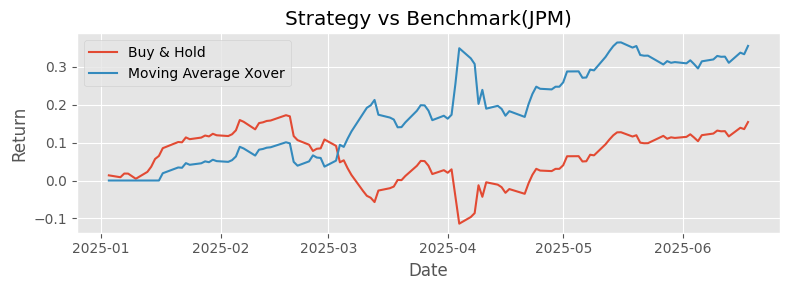

In [12]:
plt.figure(figsize = (8,3))
plt.title("Strategy vs Benchmark(JPM)")
plt.xlabel("Date")
plt.ylabel("Return")
plt.plot(df.BuyHold, label = "Buy & Hold")
plt.plot(df.MACS, label = "Moving Average Xover")
plt.legend()
plt.tight_layout()